In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy import stats
import math
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures, StandardScaler
from sklearn import tree,linear_model,neighbors
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,r2_score
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":10,"axes.titlesize":24,"axes.labelsize":24}) 
from sklearn import model_selection

# Upload data (customers model)

In [17]:
train=pd.read_csv('TrainClean.csv',index_col=0).reset_index(drop=True)
test=pd.read_csv('TestClean.csv',index_col=0).reset_index(drop=True)

columnscustomers_lasso=['HasPromotions', 'NearestCompetitor', 'Region_AreaKM2',
       'Mean_Dew_PointC', 'Mean_Sea_Level_PressurehPa', 'Precipitationmm',
       'StandardMarket', 'HyperMarket', 'ShoppingCenter', 'General',
       'WithFishDepartment', 'Region0', 'Region1', 'Region3', 'Region4',
       'Region5', 'Region6', 'Region7', 'Region8', 'Region9', 'January',
       'February', 'April', 'May', 'June', 'September', 'October', 'November',
       'December', 'Wednesday', 'Friday', 'Saturday', 'Monday', 'Thursday',
       'Fog', 'Snow']
columnssales_lasso=['IsHoliday', 'HasPromotions', 'NearestCompetitor', 'Region_AreaKM2',
       'Region_PopulationK', 'Mean_Humidity', 'Mean_Sea_Level_PressurehPa',
       'Mean_TemperatureC', 'Mean_VisibilityKm', 'Precipitationmm',
       'StandardMarket', 'HyperMarket', 'SuperMarket', 'ShoppingCenter',
       'WithFishDepartment', 'WithNonFoodDepartment', 'Region0', 'Region1',
       'Region2', 'Region3', 'Region4', 'Region6', 'Region7', 'Region8',
       'January', 'February', 'March', 'April', 'May', 'June', 'July',
       'September', 'October', 'November', 'December', 'Tuesday', 'Friday',
       'Saturday', 'Monday', 'Thursday', 'Sunday', 'Fog', 'Snow', 'Nothing',
       'Rain', 'Thunderstorm', 'NumberOfCustomers']
columnsdirect_lasso=['HasPromotions', 'NearestCompetitor', 'Region_GDP', 'Mean_Dew_PointC',
       'Mean_Sea_Level_PressurehPa', 'Precipitationmm', 'HyperMarket',
       'ShoppingCenter', 'General', 'Region0', 'Region2', 'Region3', 'Region4',
       'Region5', 'Region6', 'Region8', 'Region9', 'January', 'May', 'June',
       'September', 'October', 'November', 'December', 'Tuesday', 'Wednesday',
       'Friday', 'Saturday', 'Monday']
columnscustomers_rfs=['NearestCompetitor', 'ShoppingCenter', 'Region3', 'HasPromotions',
       'StandardMarket', 'Region7', 'General', 'Region_AreaKM2',
       'WithNonFoodDepartment', 'SuperMarket', 'Region_GDP', 'HyperMarket',
       'Monday', 'December', 'Saturday', 'Region8', 'Region_PopulationK',
       'Region0', 'Region9', 'Region2']
columnssales_rfs=['NumberOfCustomers', 'HasPromotions', 'NearestCompetitor',
       'StandardMarket', 'General', 'Monday', 'December', 'Region3',
       'Region_AreaKM2', 'Region_PopulationK', 'Region_GDP', 'Region9',
       'HyperMarket', 'Region2', 'Saturday', 'WithNonFoodDepartment',
       'ShoppingCenter', 'SuperMarket', 'Region6', 'Region0']
direcly_sales_rfs = ['NearestCompetitor', 'HasPromotions', 'HyperMarket', 'General',
       'Region3', 'December', 'Monday', 'Region_GDP', 'ShoppingCenter',
       'Saturday', 'StandardMarket', 'Mean_Sea_Level_PressurehPa',
       'Region_PopulationK', 'SuperMarket', 'Region_AreaKM2',
       'Mean_VisibilityKm', 'Mean_Humidity', 'Mean_Dew_PointC',
       'Mean_TemperatureC', 'H', 'Mean_Wind_SpeedKm_h']

# Function definition

In [3]:
def BoostingCrossvalidation(dataset, features, target, no_boosting_runs):
    
    dataset_size = dataset.shape[0]
    crossperf = []
    dataset = dataset.sample(frac=1,random_state=1234)
    k = 3
    step = math.floor(dataset_size/k)
    
    for i in range(0,dataset_size,step+1):
        perf = [] 
        model_list = []
        
        train_data, test_data = DataSplit(dataset,i,step)
    
        x = train_data[features]
        y_residual = train_data[target].values.reshape(-1,1)    
        x_test = test_data[features]
        y_test = test_data[target].values.reshape(-1,1)
    
        for i in range(no_boosting_runs):
            y_residual = DT_FittingAndEvaluation(x, x_test, y_residual, y_test, perf, model_list)
        
        crossperf.append(perf)
    
    return crossperf

In [4]:
def DataSplit(dataset,i,step):
    left_data = dataset[0:i]
    test_data = dataset[i:i+step]
    right_data = dataset[i+step+1:dataset.shape[0]]        
    train_data = left_data.append(right_data)
    train_data = train_data.reset_index(drop=True)
    return train_data, test_data

In [5]:
def DT_FittingAndEvaluation(x, x_test, y_residual, y_test, perf, model_list):
    y_residual = DT_Fitting(x, y_residual, model_list)
    result=GradientBoosting_eval(model_list,x_test)
    perf.append(r2_score(y_test,result))
    perf[-20:]
    return y_residual

In [6]:
def DT_Fitting(x, y_residual, model_list):
    clf = tree.DecisionTreeRegressor(max_depth=6)
    clf = clf.fit(x, y_residual)
    model_list.append(clf)
    yp = clf.predict(x).reshape(-1,1)
    y_residual = y_residual-yp
    return y_residual

In [7]:
def GradientBoosting_eval(models,data_to_predict):
    prediction = np.zeros((len(data_to_predict),1))
    for model in models:
        yp = model.predict(data_to_predict).reshape(-1,1)
        prediction += yp
    return prediction.reshape(-1,1)

In [8]:
def GradientBoosting_performances(crossperf):
    finalperf = []
    for i in range(len(crossperf[0])):
        perflist=[]
        for performance in crossperf:
            perflist.append(performance[i])
        finalperf.append(np.average(perflist))
        del perflist
        print("Boosting %d : %d modelli - R2: %f\n" % (i,i+1,finalperf[i]))
    plt.plot(np.ones(len(finalperf))-finalperf)

## Prediction functions

In [9]:
def DoubleBoostingCrossvalidation(dataset, first_features, first_target, second_features, second_target, no_boosting_runs):
    
    dataset_size = dataset.shape[0]
    crossperf = []
    dataset = dataset.sample(frac=1,random_state=1234)
    k = 3
    step = math.floor(dataset_size/k)
    
    for i in range(0,dataset_size,step+1):
        perf = [] 
        model_list = []
    
        train_data, test_data = DataSplit(dataset,i,step)
        
        x = train_data[first_features]
        y_residual = train_data[first_target].values.reshape(-1,1)    
        x_test = test_data[first_features]
        y_test = test_data[first_target].values.reshape(-1,1)
    
        for i in range(no_boosting_runs):
            y_residual = DT_FittingAndEvaluation(x, x_test, y_residual, y_test, perf, model_list)
        
        predicted_cust = GradientBoosting_eval(model_list,x)
        predicted_cust_test = GradientBoosting_eval(model_list,x_test)
        
        perf = [] 
        model_list = []
        
        x = train_data[second_features]
        y_residual = train_data[second_target].values.reshape(-1,1)    
        x_test = test_data[second_features].drop(columns='NumberOfCustomers',axis=1) 
        x_test['NumberOfCustomers'] = predicted_cust_test       #test should be evaluated on predicted customers
        y_test = test_data[second_target].values.reshape(-1,1)
        
        for i in range(no_boosting_runs):
            y_residual = DT_FittingAndEvaluation(x, x_test, y_residual, y_test, perf, model_list)
        
        crossperf.append(perf)
    
    return crossperf

In [10]:
## Not used yet, useful for future customers prediction for delivery
def Model_Building(dataset, features, target, no_boosting_runs):
    model_list = []
    
    x = dataset[features]
    y_residual = dataset[target].values.reshape(-1,1)    
    
    prediction = np.zeros((len(y),1))
    
    for i in range(no_boosting_runs):
        y_residual = DT_Fitting(x, y_residual, model_list)
    
    return model_list

# Predict Sales direclty

Boosting 0 : 1 modelli - R2: 0.277673

Boosting 1 : 2 modelli - R2: 0.349996

Boosting 2 : 3 modelli - R2: 0.397897

Boosting 3 : 4 modelli - R2: 0.426668

Boosting 4 : 5 modelli - R2: 0.441475

Boosting 5 : 6 modelli - R2: 0.459851

Boosting 6 : 7 modelli - R2: 0.482558

Boosting 7 : 8 modelli - R2: 0.497994

Boosting 8 : 9 modelli - R2: 0.519253

Boosting 9 : 10 modelli - R2: 0.532986

Boosting 10 : 11 modelli - R2: 0.551388

Boosting 11 : 12 modelli - R2: 0.561515

Boosting 12 : 13 modelli - R2: 0.573934

Boosting 13 : 14 modelli - R2: 0.582791

Boosting 14 : 15 modelli - R2: 0.590967

Boosting 15 : 16 modelli - R2: 0.596961

Boosting 16 : 17 modelli - R2: 0.612196

Boosting 17 : 18 modelli - R2: 0.615822

Boosting 18 : 19 modelli - R2: 0.621574

Boosting 19 : 20 modelli - R2: 0.626293

Boosting 20 : 21 modelli - R2: 0.633870

Boosting 21 : 22 modelli - R2: 0.639153

Boosting 22 : 23 modelli - R2: 0.643741

Boosting 23 : 24 modelli - R2: 0.649228

Boosting 24 : 25 modelli - R2: 0.63

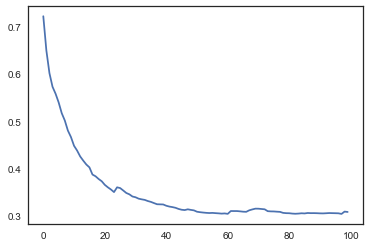

In [20]:
crossperf = BoostingCrossvalidation(train, columnsdirect_lasso, 'NumberOfSales', 100)

GradientBoosting_performances(crossperf)

# Double Prediction

Boosting 0 : 1 modelli - R2: 0.402006

Boosting 1 : 2 modelli - R2: 0.426997

Boosting 2 : 3 modelli - R2: 0.433842

Boosting 3 : 4 modelli - R2: 0.443067

Boosting 4 : 5 modelli - R2: 0.451145

Boosting 5 : 6 modelli - R2: 0.455197

Boosting 6 : 7 modelli - R2: 0.458318

Boosting 7 : 8 modelli - R2: 0.461938

Boosting 8 : 9 modelli - R2: 0.465245

Boosting 9 : 10 modelli - R2: 0.469342

Boosting 10 : 11 modelli - R2: 0.473368

Boosting 11 : 12 modelli - R2: 0.475552

Boosting 12 : 13 modelli - R2: 0.476939

Boosting 13 : 14 modelli - R2: 0.478376

Boosting 14 : 15 modelli - R2: 0.477819

Boosting 15 : 16 modelli - R2: 0.480078

Boosting 16 : 17 modelli - R2: 0.482161

Boosting 17 : 18 modelli - R2: 0.483414

Boosting 18 : 19 modelli - R2: 0.485703

Boosting 19 : 20 modelli - R2: 0.486850

Boosting 20 : 21 modelli - R2: 0.487991

Boosting 21 : 22 modelli - R2: 0.489024

Boosting 22 : 23 modelli - R2: 0.490192

Boosting 23 : 24 modelli - R2: 0.491337

Boosting 24 : 25 modelli - R2: 0.49

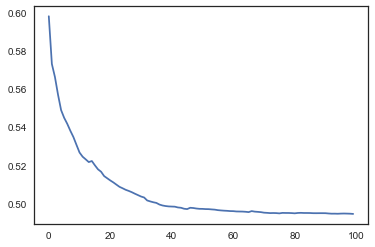

In [21]:
crossperf = DoubleBoostingCrossvalidation(train, columnscustomers_lasso, 'NumberOfCustomers', columnssales_lasso, 'NumberOfSales', 100)
GradientBoosting_performances(crossperf)